In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info
Supports 'natural'/'bitreversed' input and forward/inverse transform. Written with 18bit fixed-point format using the R2SDF structure. Note that the R2SDF has complex multiplier after each stage but the last, this could be optimized in the future; possible to save 2x multipliers.

This is a rounded core, so there will not be any DC-bias introduced!

## Output ordering is different from numpy
Numpy has `Natural(in) -> Natural(out)` ordering. 

This cores provide either `Natural -> Bitreversed` or `Bitreversed -> Natural` ordering. This is the side-effect of Radix-2 algorithm, this can be fixed with the 'Bitreversal' core.

## Scaling is different from numpy
Numpy scales `fft_out *= FFT_LENGHT` and `ifft_out /= FFT_LENGHT`. 

This core works in oppsite i.e. `fft_out /= FFT_LENGHT` and `ifft_out *= FFT_LENGHT`. This way the values always stay in -1 ... 1 range.

## Coefficients are stored as constants in LUTs
Storing 18bit coefficients for large FFT can take huge amounts of LUTS. I recommend using bitwidth of ~9, this gives quite optimal packing. Note that ~9 bit coefficents might look bad on synthetic signals but are acutally very much usable on real-life signals.

# Examples

## Forward FFT

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 1024/1024 [00:00<00:00, 2671.22it/s]
INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 745)
INFO:sim:Hardware delay is 279


<IPython.core.display.Javascript object>


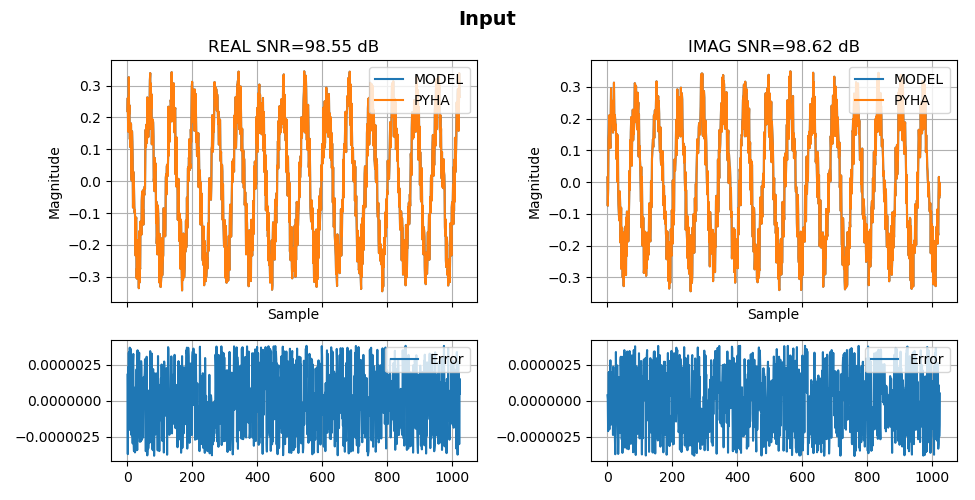

<IPython.core.display.Javascript object>


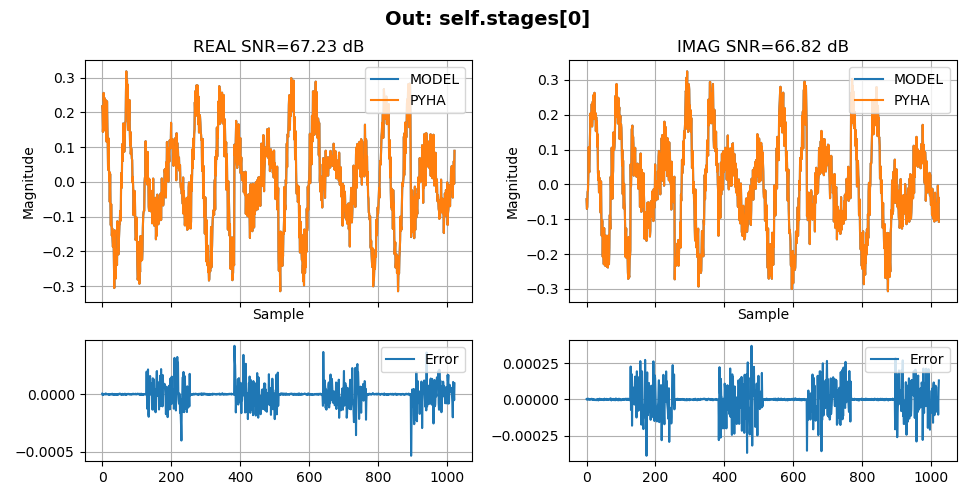

<IPython.core.display.Javascript object>


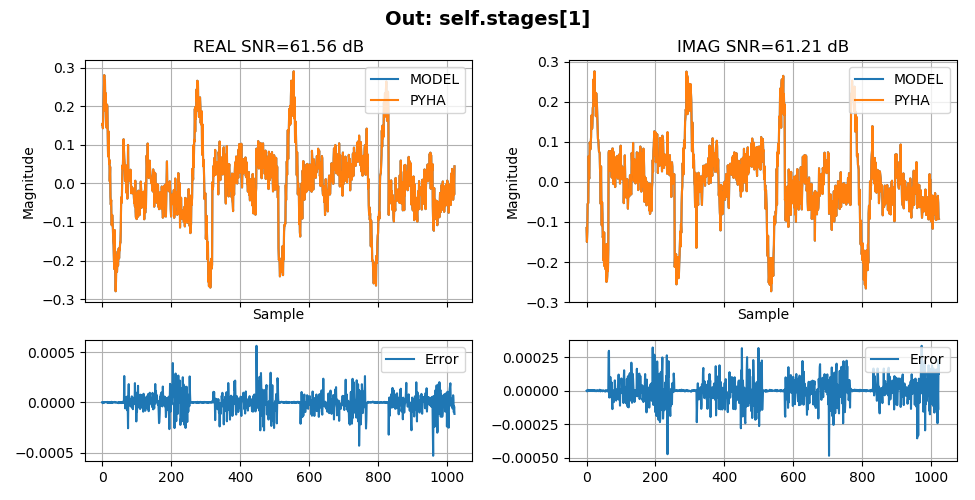

<IPython.core.display.Javascript object>


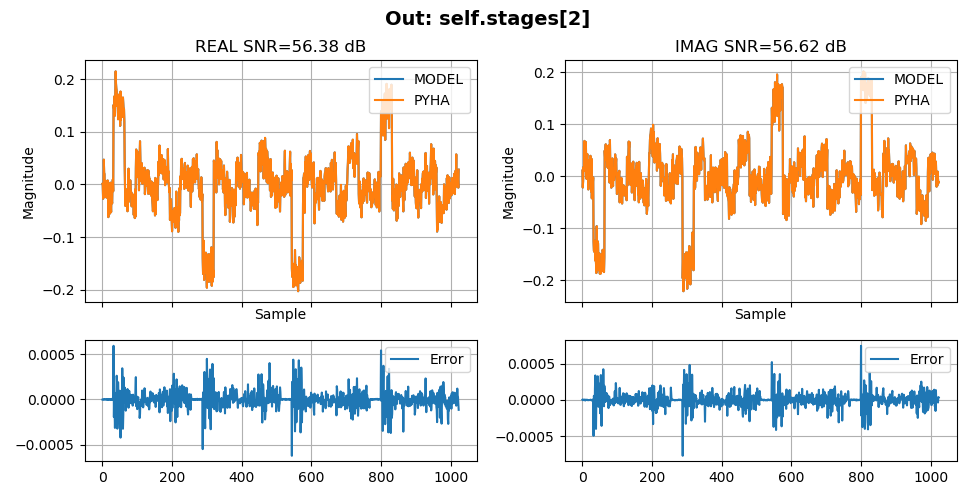

<IPython.core.display.Javascript object>


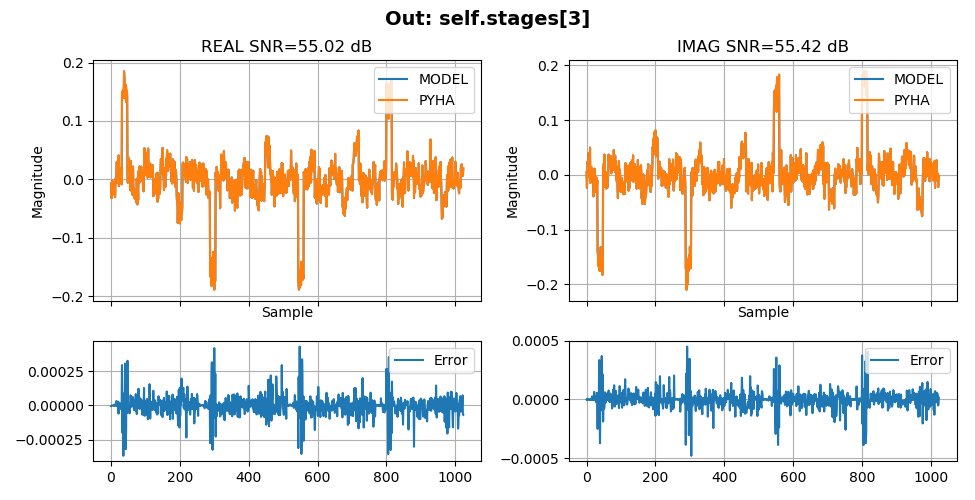

<IPython.core.display.Javascript object>


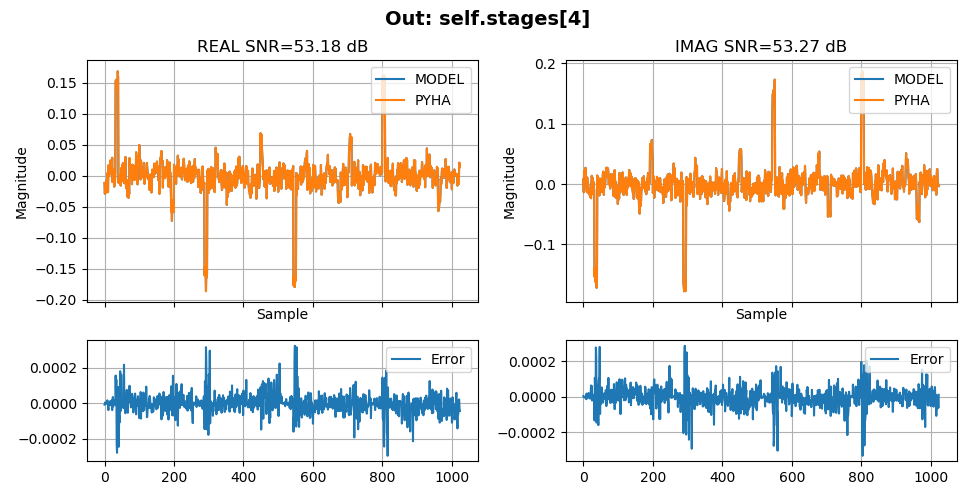

<IPython.core.display.Javascript object>


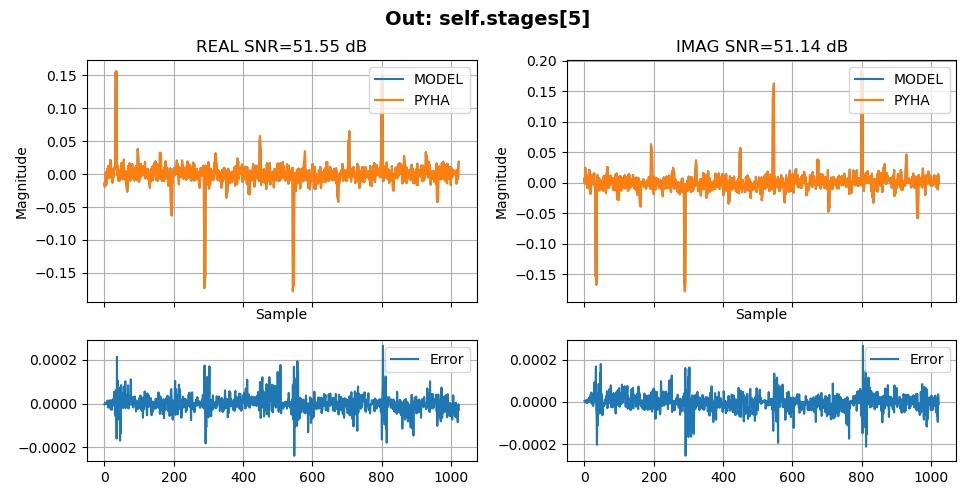

<IPython.core.display.Javascript object>


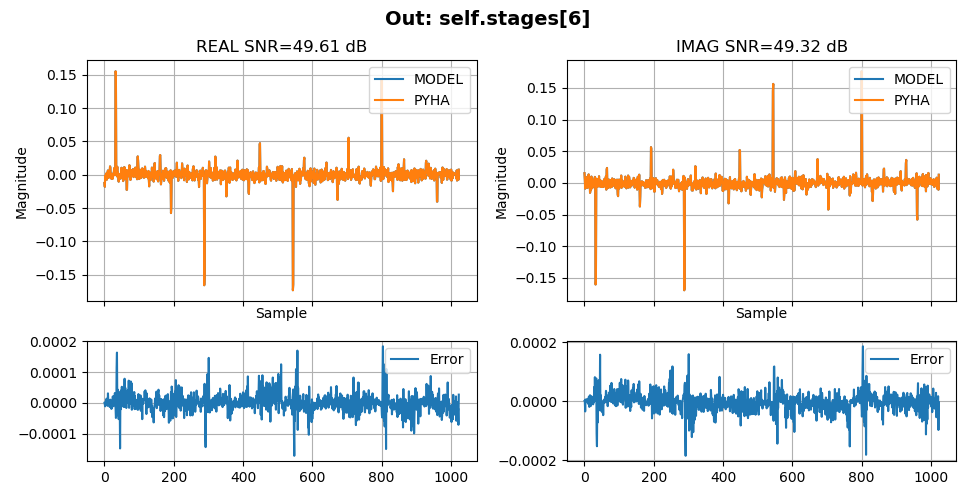

<IPython.core.display.Javascript object>


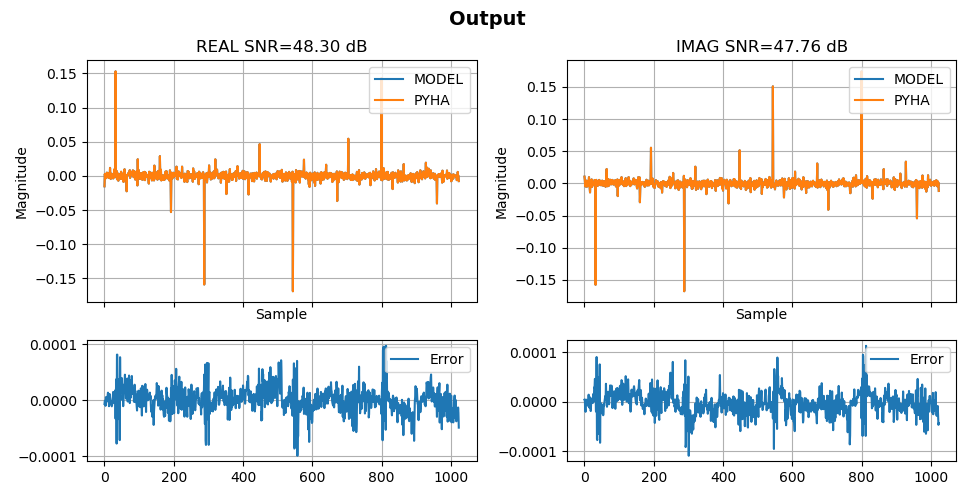

In [14]:
import numpy as np
fft_size = 256
samples = 1024
freq = 15
sine = np.exp(2j*np.pi*np.linspace(0, 1, samples)*freq) * 0.25
noise = np.random.uniform(-1, 1, samples) + np.random.uniform(-1, 1, samples) * 1j
forward_input_signal = sine + noise * 0.1

dut = R2SDF(fft_size, twiddle_bits=9)
forward_fft_sim = Simulator(dut, trace=True).run(forward_input_signal) # run simulations and gather trace
forward_fft_sim.plot_trace()

## Inverse FFT

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 1024/1024 [00:00<00:00, 2351.23it/s]
INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 745)
ERROR:complex:WRAP -1.51562-0.966797j -> 0.484375-0.966797j	[]
ERROR:complex:WRAP -1.51562-0.966797j -> 0.484375-0.966797j	[]
ERROR:complex:WRAP 0.96875-1.93359j -> 0.96875+0.0664062j	[]
INFO:sim:Hardware delay is 279


<IPython.core.display.Javascript object>


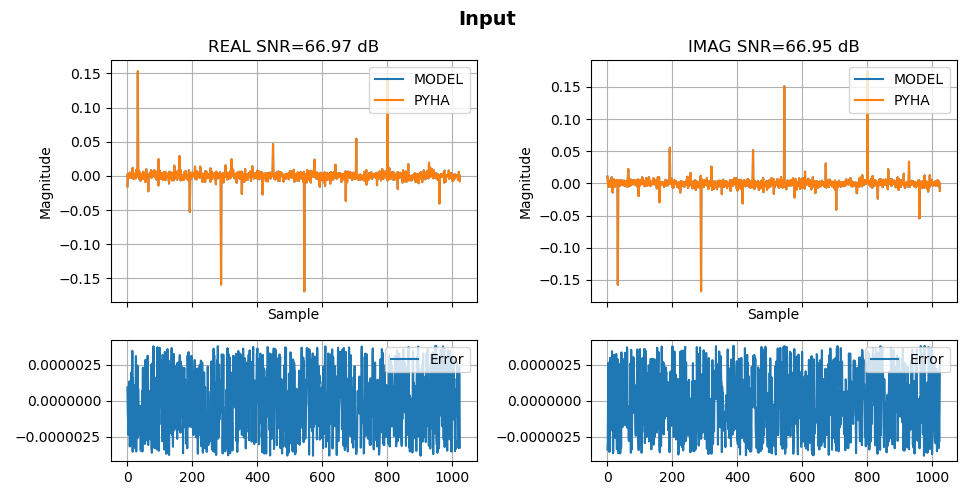

<IPython.core.display.Javascript object>


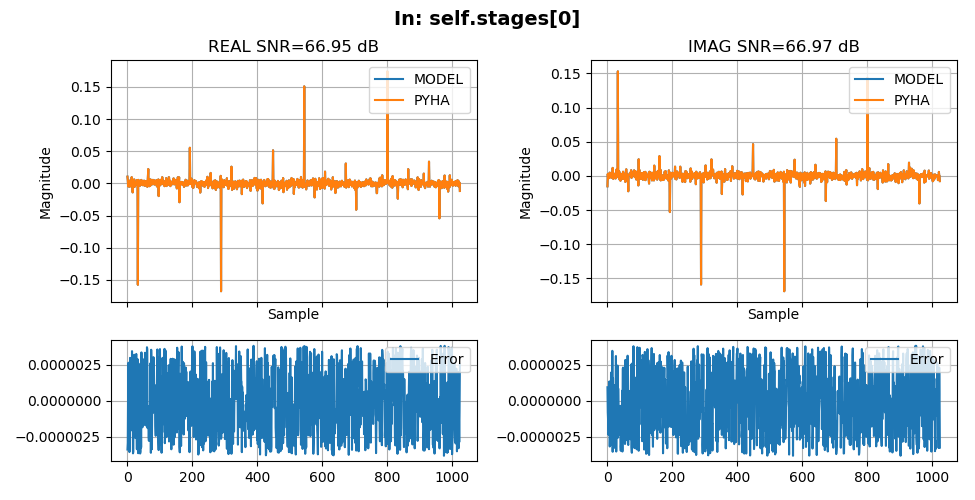

<IPython.core.display.Javascript object>


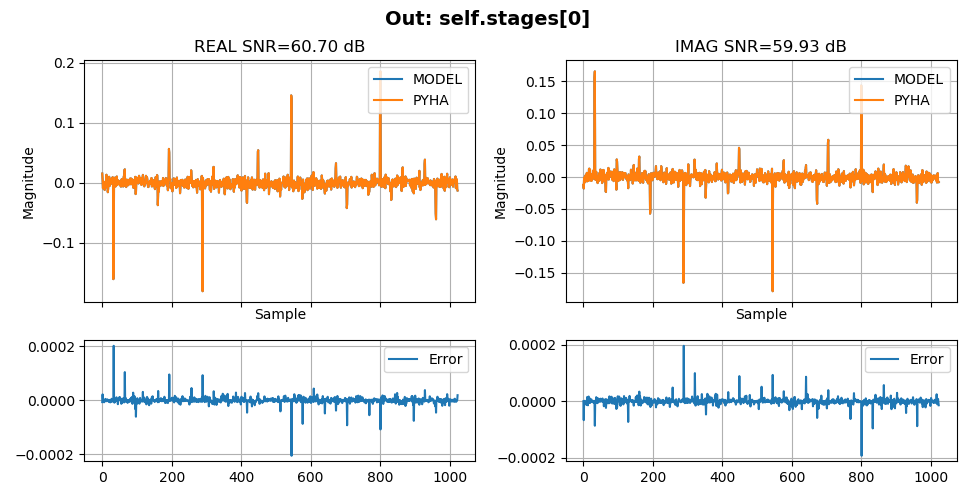

<IPython.core.display.Javascript object>


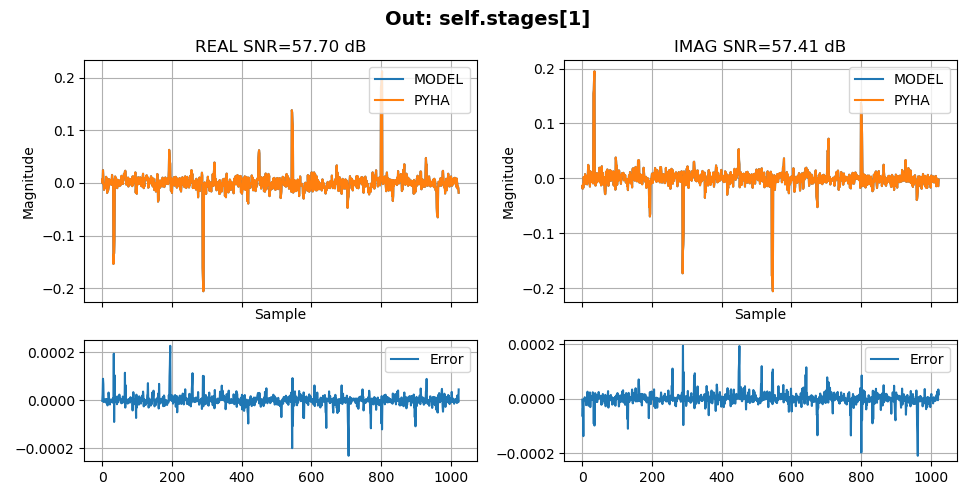

<IPython.core.display.Javascript object>


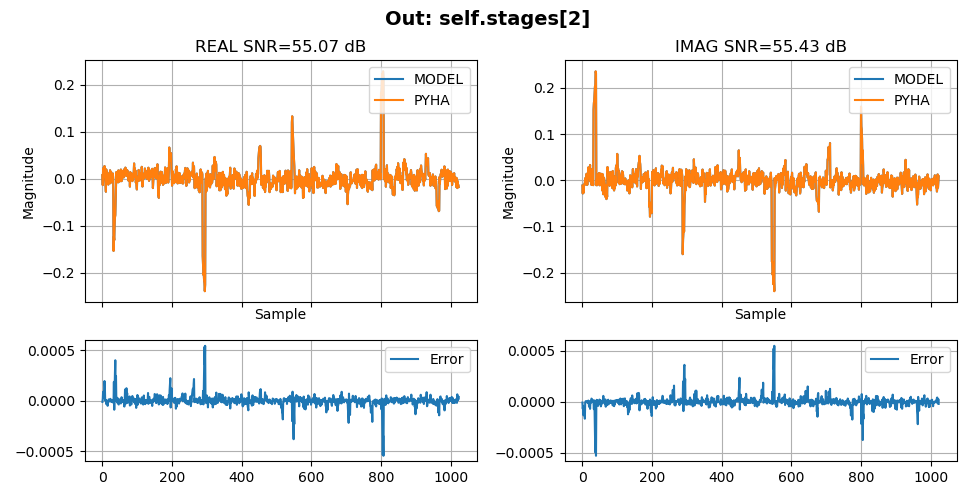

<IPython.core.display.Javascript object>


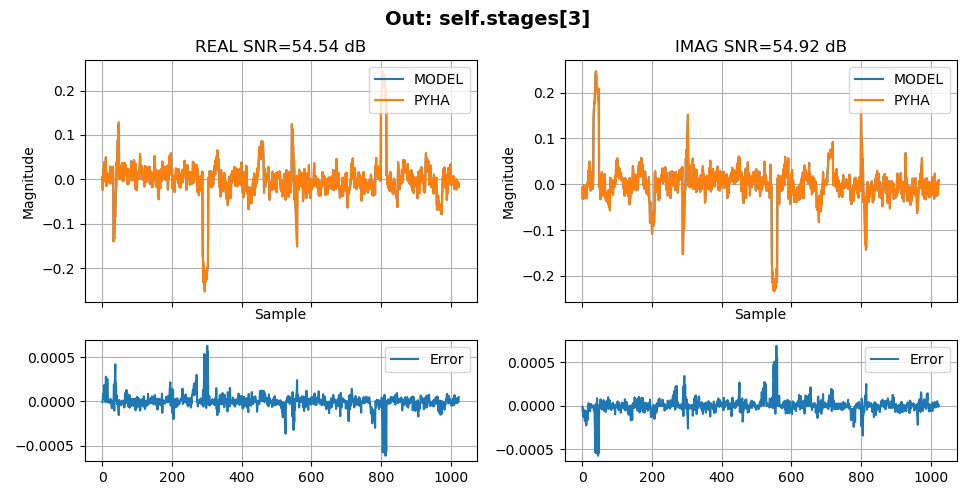

<IPython.core.display.Javascript object>


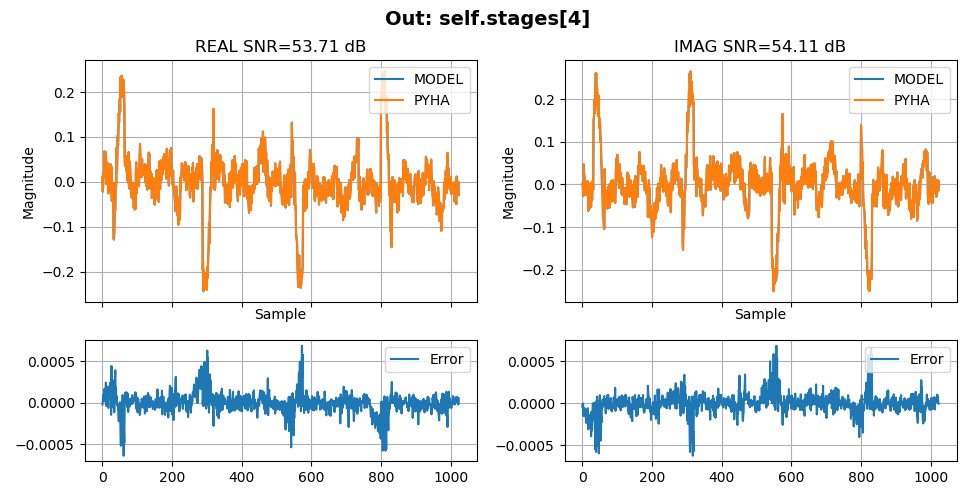

<IPython.core.display.Javascript object>


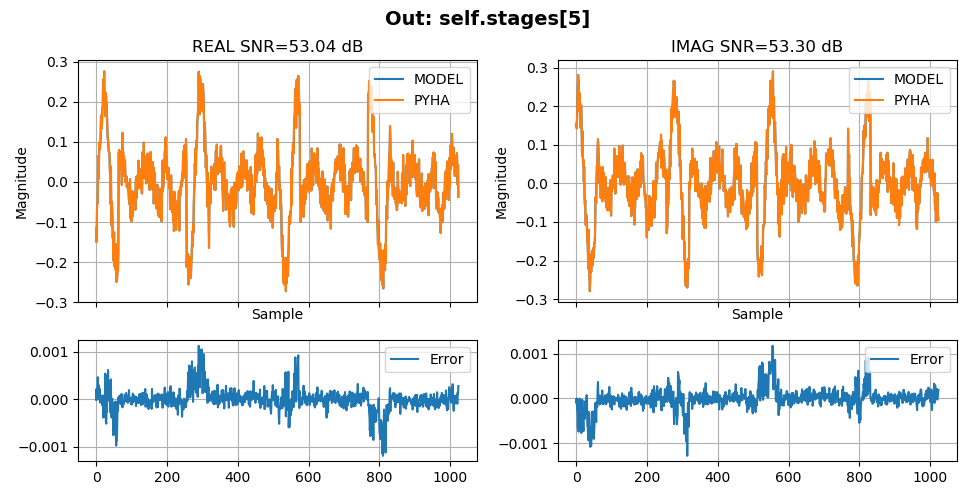

<IPython.core.display.Javascript object>


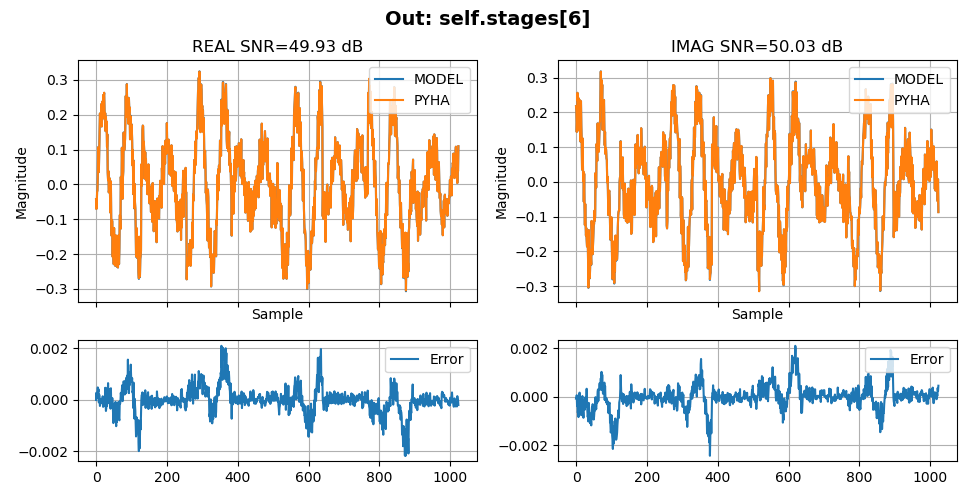

<IPython.core.display.Javascript object>


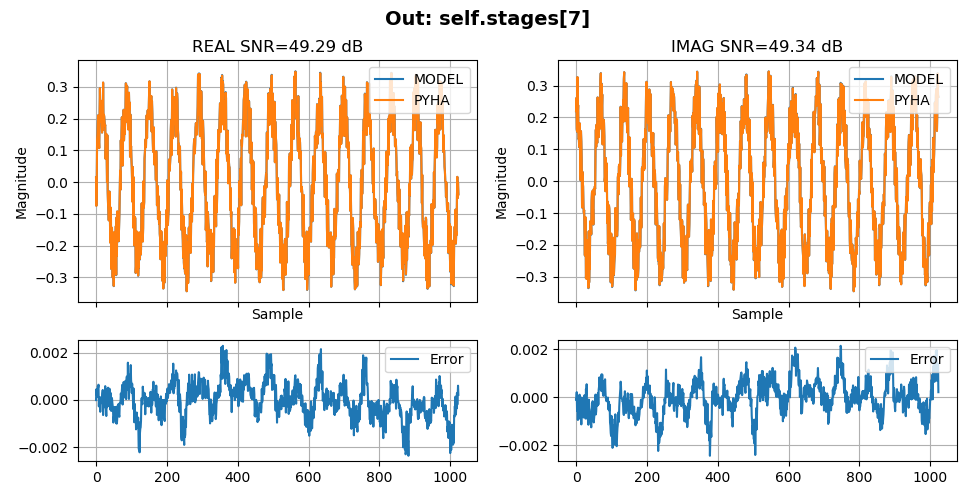

<IPython.core.display.Javascript object>


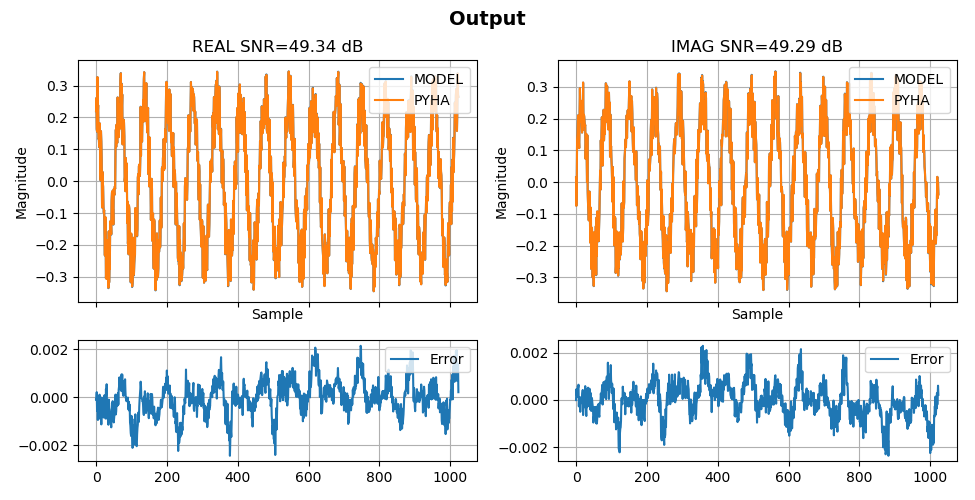

In [19]:
# use input from the forward FFT, that is in 'bitreversed' format.
inverse_input=forward_fft_sim.out[0][0]
dut = R2SDF(fft_size, twiddle_bits=9, inverse=True, input_ordering='bitreversed')
sim = Simulator(dut, trace=True).run(forward_fft_sim.out[0][0])
sim.plot_trace()

# Conversion to VHDL and RTL/NETLIST simulations

## Forward FFT

In [17]:
# Pyha design can be converted to VHDL after the PYHA simulation has been ran
# VHDL sources can be used to run the RTL simulation, in addition NETLIST simulation is supported (after Quartus mapper)
# Pyha automatically manages everything needed if you specify the 'RTL', 'NETLIST' flags.
output_dir = '~/Documents/pyha_output'
dut = R2SDF(fft_size, twiddle_bits=9)
vhdl_sim = Simulator(dut, output_dir=output_dir, extra_simulations=['RTL', 'NETLIST']).run(forward_input_signal)
vhdl_sim.assert_equal(atol=1e-3, rtol=1e-3)

INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 1024/1024 [00:02<00:00, 425.47it/s]
INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 745)
INFO:sim:Hardware delay is 279
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO

### Synthesis:  resource usage and Fmax

In [18]:
print(vhdl_sim.quartus.get_resource_usage('fit'))
print(vhdl_sim.quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 2,207 / 39,600 ( 6 % )
    Total combinational functions : 2,038 / 39,600 ( 5 % )
    Dedicated logic registers : 1,295 / 39,600 ( 3 % )
Total registers : 1295
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 8,640 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 56 / 232 ( 24 % )
Total PLLs : 0 / 4 ( 0 % )

+-------------------------------------------------+
; Fmax Summary                                    ;
+-----------+-----------------+------------+------+
; Fmax      ; Restricted Fmax ; Clock Name ; Note ;
+-----------+-----------------+------------+------+
; 99.58 MHz ; 99.58 MHz       ; clk        ;      ;
+-----------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by 

## Inverse FFT

In [24]:
output_dir = '~/Documents/pyha_output'
dut = R2SDF(fft_size, twiddle_bits=9, inverse=True, input_ordering='bitreversed')
inv_vhdl_sim = Simulator(dut, output_dir=output_dir, extra_simulations=['RTL', 'NETLIST']).run(inverse_input[:fft_size])
inv_vhdl_sim.assert_equal(atol=1e-2, rtol=1e-2)

INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 256/256 [00:00<00:00, 413.67it/s]
INFO:sim:Flushing the pipeline to collect 256 valid samples (currently have 0)
ERROR:complex:WRAP 0.649414-1.08789j -> 0.649414+0.912109j	[R2SDF.main()-StageR2SDF.main()-StageR2SDF.butterfly()]
ERROR:complex:WRAP 0.649414-1.08789j -> 0.649414+0.912109j	[R2SDF.main()-StageR2SDF.main()-StageR2SDF.butterfly()]
ERROR:complex:WRAP 1.29883+1.82422j -> -0.701172-0.175781j	[R2SDF.main()-StageR2SDF.main()-StageR2SDF.butterfly()]
INFO:sim:Hardware delay is 279
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegist

### Synthesis:  resource usage and Fmax

In [25]:
print(inv_vhdl_sim.quartus.get_resource_usage('fit'))
print(inv_vhdl_sim.quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 2,223 / 39,600 ( 6 % )
    Total combinational functions : 2,083 / 39,600 ( 5 % )
    Dedicated logic registers : 1,256 / 39,600 ( 3 % )
Total registers : 1256
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 8,748 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 56 / 232 ( 24 % )
Total PLLs : 0 / 4 ( 0 % )



/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory


+-------------------------------------------------+
; Fmax Summary                                    ;
+-----------+-----------------+------------+------+
; Fmax      ; Restricted Fmax ; Clock Name ; Note ;
+-----------+-----------------+------------+------+
; 95.85 MHz ; 95.85 MHz       ; clk        ;      ;
+-----------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by the same clock.  Paths of different clocks, including generated clocks, are ignored.  For paths between a clock and its inversion, FMAX is computed as if the rising and falling edges are scaled along with FMAX, such that the duty cycle (in terms of a percentage) is maintained. Altera recommends that you always use clock constraints and other slack reports for sign-off analysis.

